[*********************100%***********************]  22 of 22 completed
Testing Stationarity of Spreads: 100%|████████| 168/168 [00:04<00:00, 41.59it/s]


Stationary Pairs (p < 0.1): 11
Pairs: [('APA', 'PSX'), ('BKR', 'WMB'), ('CVX', 'EOG'), ('DVN', 'OXY'), ('HAL', 'PSX'), ('HES', 'MPC'), ('HES', 'VLO'), ('MPC', 'VLO'), ('MPC', 'XOM'), ('PSX', 'SLB'), ('VLO', 'XOM')]


Optimizing Parameters: 100%|████████████████████| 11/11 [00:41<00:00,  3.73s/it]


Total Optimized Pairs: 11

Performance by Pair:
Pair: ('APA', 'PSX'), Final Portfolio Value: 8.86, Cumulative Return: -2.49%


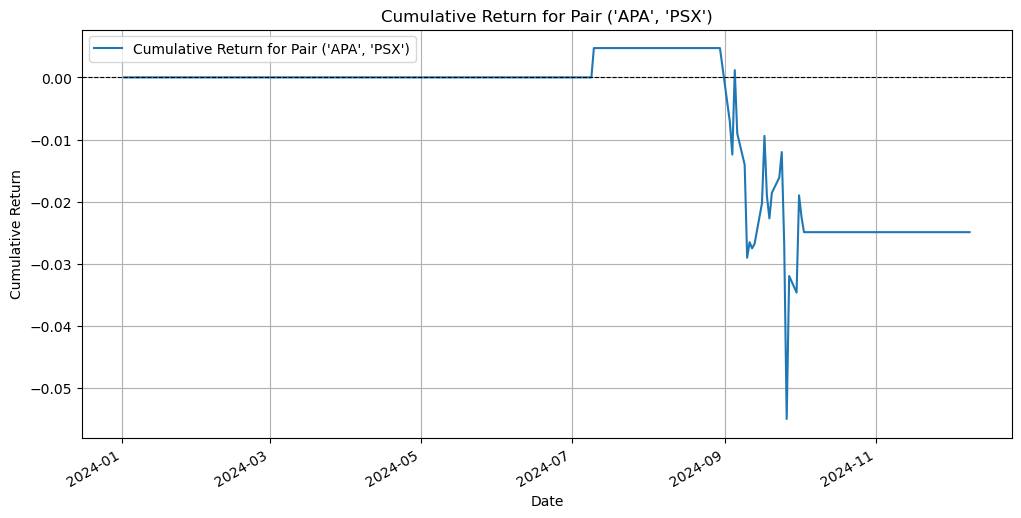

Pair: ('BKR', 'WMB'), Final Portfolio Value: 9.39, Cumulative Return: 3.31%


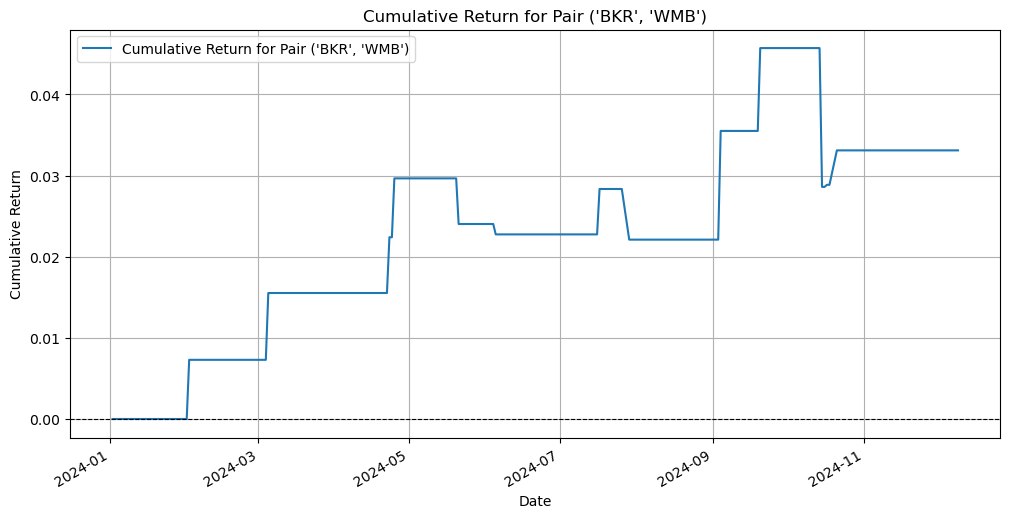

Pair: ('CVX', 'EOG'), Final Portfolio Value: 9.32, Cumulative Return: 2.53%


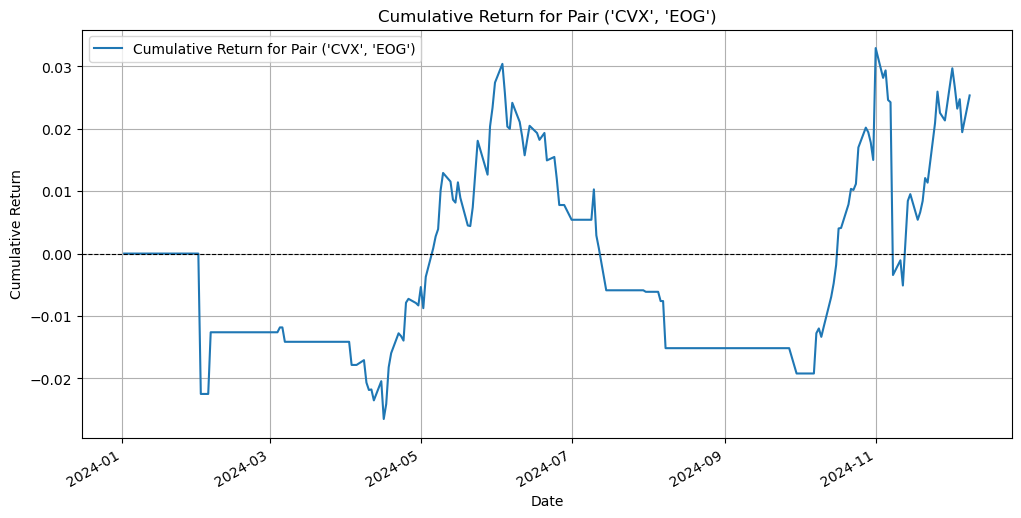

Pair: ('DVN', 'OXY'), Final Portfolio Value: 9.18, Cumulative Return: 0.94%


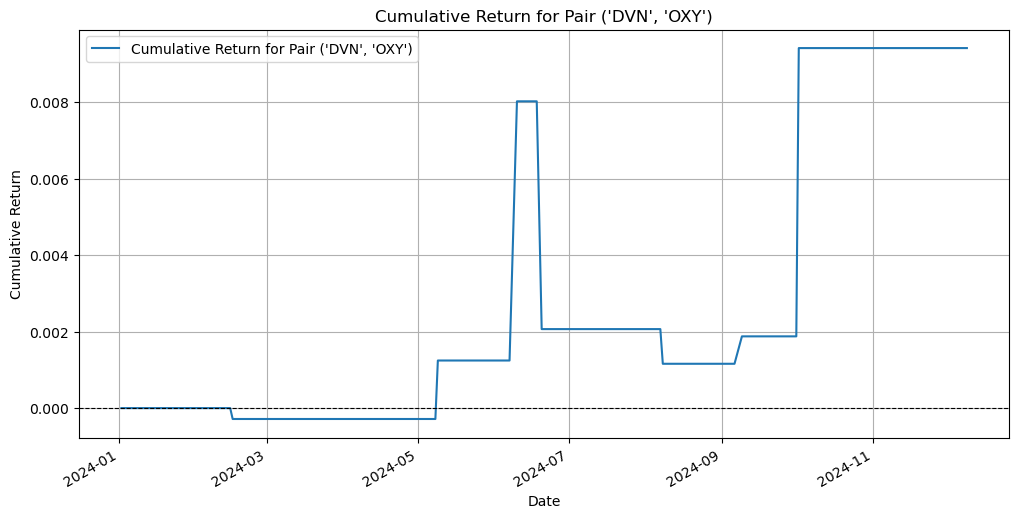

Pair: ('HAL', 'PSX'), Final Portfolio Value: 9.32, Cumulative Return: 2.55%


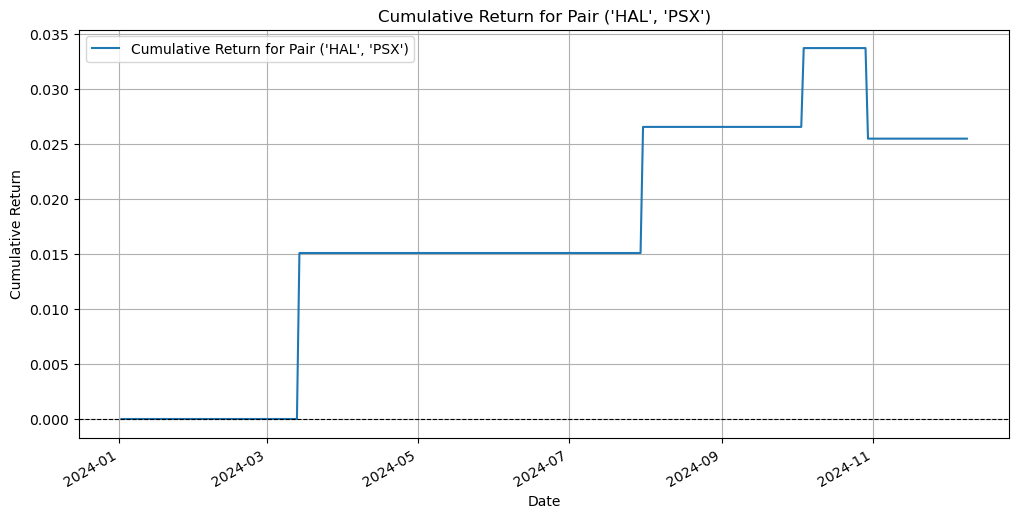

Pair: ('HES', 'MPC'), Final Portfolio Value: 9.08, Cumulative Return: -0.15%


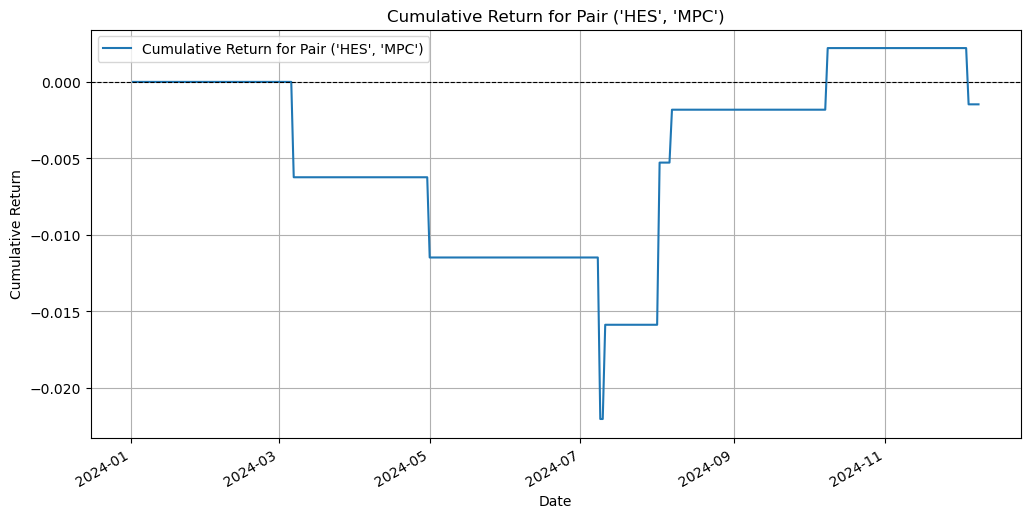

Pair: ('HES', 'VLO'), Final Portfolio Value: 9.26, Cumulative Return: 1.85%


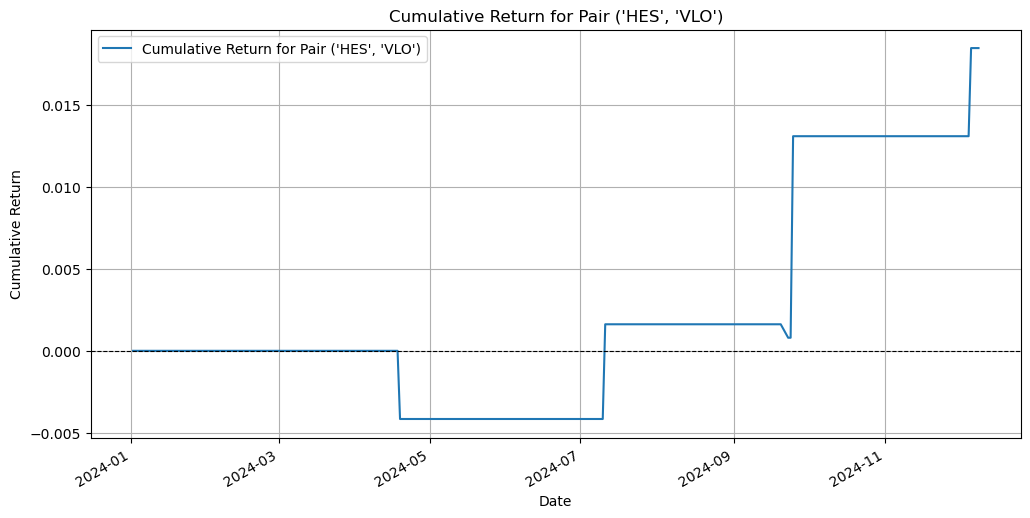

Pair: ('MPC', 'VLO'), Final Portfolio Value: 9.12, Cumulative Return: 0.31%


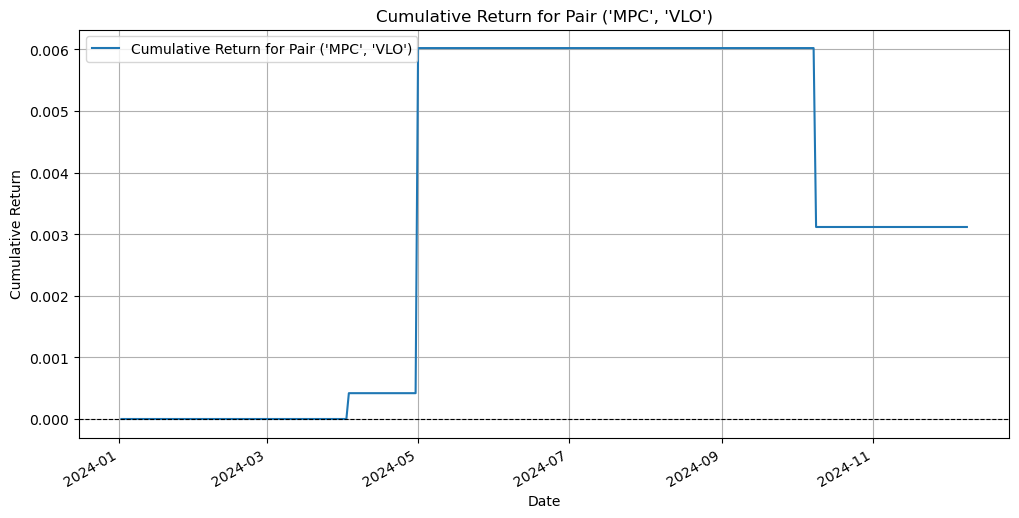

Pair: ('MPC', 'XOM'), Final Portfolio Value: 9.55, Cumulative Return: 5.05%


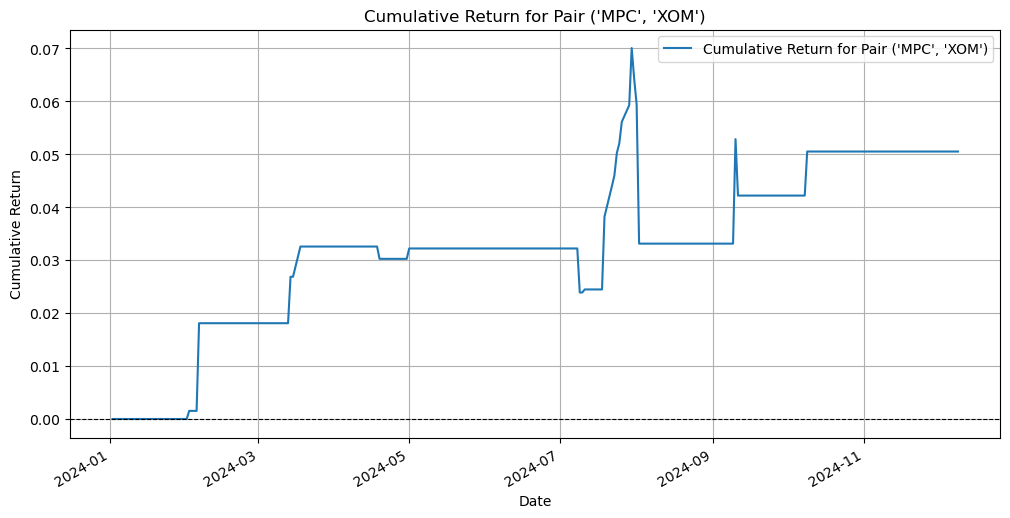

Pair: ('PSX', 'SLB'), Final Portfolio Value: 9.35, Cumulative Return: 2.82%


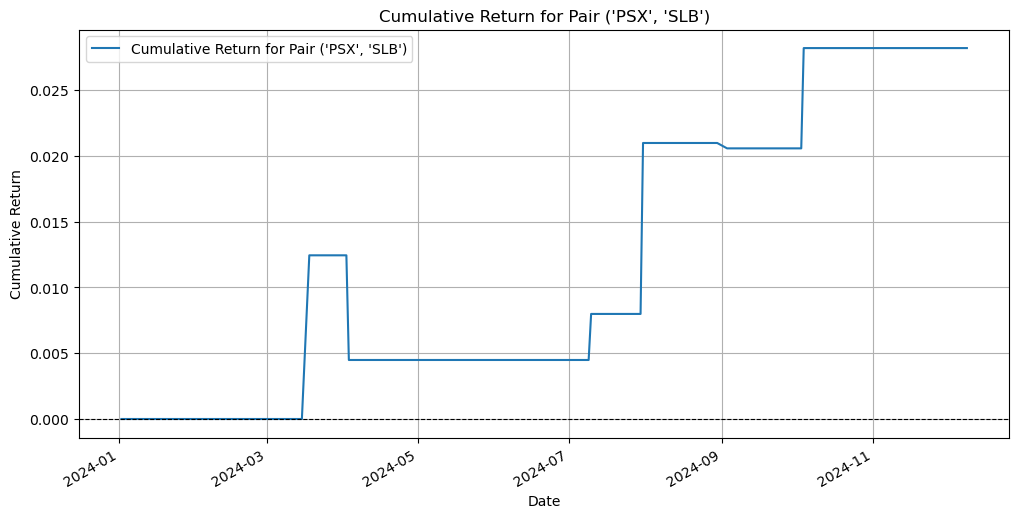

Pair: ('VLO', 'XOM'), Final Portfolio Value: 9.59, Cumulative Return: 5.54%


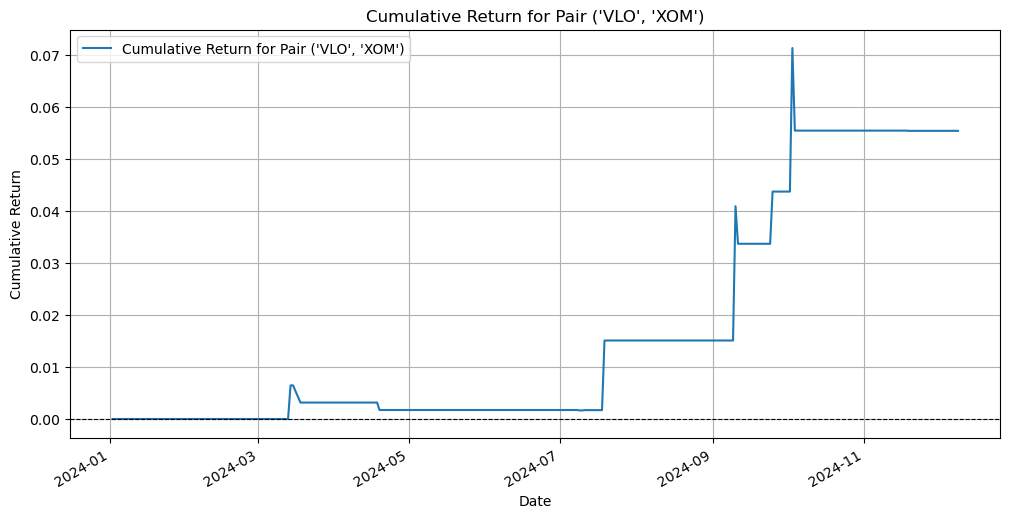

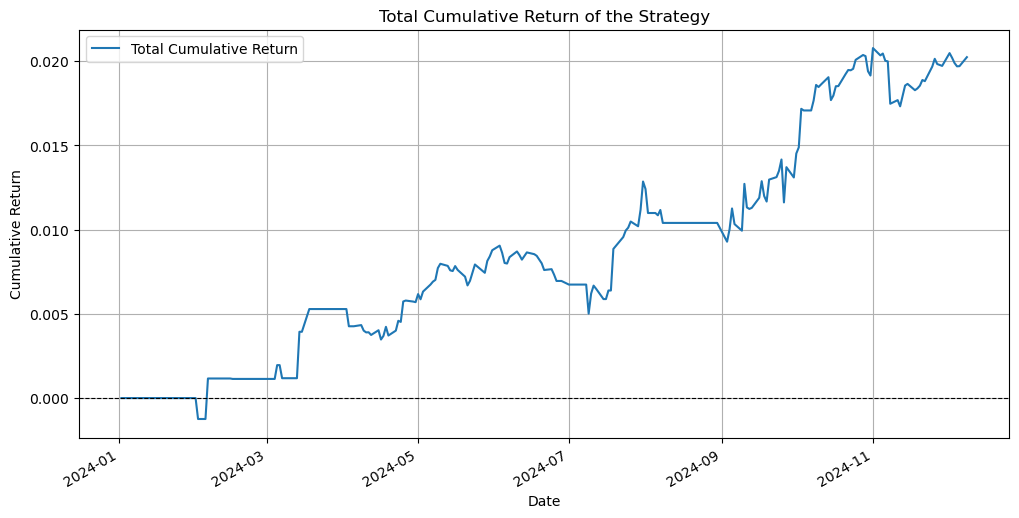

In [182]:
import pandas as pd
import yfinance as yf
import numpy as np
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import combinations, product

# Function to get highly correlated pairs
def get_highly_correlated_pairs(corr_matrix, threshold=0.9):
    correlated_pairs = []
    tickers = corr_matrix.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            if corr_matrix.iloc[i, j] >= threshold:
                correlated_pairs.append((tickers[i], tickers[j]))
    return correlated_pairs

# Function to find pairs with stationary spreads
def find_stationary_spreads(data, pairs, significance_level=0.1):
    """
    Identify pairs with stationary spreads based on the ADF test.

    Parameters:
    - data: DataFrame of stock prices.
    - pairs: List of stock pairs.
    - significance_level: p-value threshold for stationarity.

    Returns:
    - stationary_pairs: List of pairs with stationary spreads.
    - pvalues: List of p-values for the spreads.
    """
    stationary_pairs = []
    pvalues = []

    for pair in tqdm(pairs, desc="Testing Stationarity of Spreads"):
        s1 = data[pair[0]]
        s2 = data[pair[1]]
        spread = s1 - s2
        adf_result = adfuller(spread.dropna())  # Perform ADF test
        pvalue = adf_result[1]

        if pvalue < significance_level:
            stationary_pairs.append(pair)
            pvalues.append(pvalue)

    print(f"Stationary Pairs (p < {significance_level}): {len(stationary_pairs)}")
    print(f"Pairs: {stationary_pairs}")
    return stationary_pairs, pvalues

def simulate_pair_strategy_fixed_exit(data, pair, entry_level, take_profit, stop_loss, initial_cash):
    s1, s2 = pair
    spread = data[s1] - data[s2]
    rolling_mean = spread.rolling(window=21).mean()
    rolling_std = spread.rolling(window=21).std()
    std_diff = (spread - rolling_mean) / rolling_std

    cash = initial_cash
    portfolio_value = initial_cash
    position = 0  # +1 for long spread, -1 for short spread, 0 for no position
    shares1 = shares2 = entry_price1 = entry_price2 = 0
    entry_mean = entry_std = None  # Initialize variables to store entry stats
    portfolio_values = []

    for i in range(len(data)):
        if i < 21:  # Skip initial period before rolling calculations
            portfolio_values.append(portfolio_value)
            continue

        current_price1 = data[s1].iloc[i]
        current_price2 = data[s2].iloc[i]
        current_std_diff = std_diff.iloc[i]

        # Update portfolio value daily based on open position
        if position == -1:  # Short spread
            portfolio_value = (
                cash
                + shares1 * (entry_price1 - current_price1)  # P&L from short Stock 1
                + shares2 * (current_price2 - entry_price2)  # P&L from long Stock 2
            )
        elif position == 1:  # Long spread
            portfolio_value = (
                cash
                + shares1 * (current_price1 - entry_price1)  # P&L from long Stock 1
                + shares2 * (entry_price2 - current_price2)  # P&L from short Stock 2
            )
        else:  # No position
            portfolio_value = cash

        portfolio_values.append(portfolio_value)

        # Entry Rules
        if position == 0:
            if current_std_diff > entry_level:  # Short the spread
                position = -1
                shares1 = (cash / 2) / current_price1
                shares2 = (cash / 2) / current_price2
                entry_price1 = current_price1
                entry_price2 = current_price2
                entry_mean = rolling_mean.iloc[i]
                entry_std = rolling_std.iloc[i]
            elif current_std_diff < -entry_level:  # Long the spread
                position = 1
                shares1 = (cash / 2) / current_price1
                shares2 = (cash / 2) / current_price2
                entry_price1 = current_price1
                entry_price2 = current_price2
                entry_mean = rolling_mean.iloc[i]
                entry_std = rolling_std.iloc[i]

        # Exit Rules
        elif position == -1:  # Short spread
            exit_level = entry_mean - take_profit * entry_std  # Take profit threshold
            stop_loss_level = entry_mean + stop_loss * entry_std  # Stop loss threshold
            if spread.iloc[i] <= exit_level or spread.iloc[i] > stop_loss_level:
                cash += shares1 * (entry_price1 - current_price1)  # Close short Stock 1
                cash += shares2 * (current_price2 - entry_price2)  # Close long Stock 2
                position = 0
                shares1 = shares2 = entry_price1 = entry_price2 = 0
                entry_mean = entry_std = None

        elif position == 1:  # Long spread
            exit_level = entry_mean + take_profit * entry_std  # Take profit threshold
            stop_loss_level = entry_mean - stop_loss * entry_std  # Stop loss threshold
            if spread.iloc[i] >= exit_level or spread.iloc[i] < stop_loss_level:
                cash += shares1 * (current_price1 - entry_price1)  # Close long Stock 1
                cash += shares2 * (entry_price2 - current_price2)  # Close short Stock 2
                position = 0
                shares1 = shares2 = entry_price1 = entry_price2 = 0
                entry_mean = entry_std = None


    portfolio_values = pd.Series(portfolio_values, index=data.index)
    cumulative_return = (portfolio_values / initial_cash) - 1
    return portfolio_values, cumulative_return, portfolio_values.iloc[-1]


# Optimize parameters for each pair using training data
def optimize_parameters(data, pairs, entry_levels, take_profits, stop_losses, initial_cash=100):
    optimal_params = {}

    for pair in tqdm(pairs, desc="Optimizing Parameters"):
        results = []

        # Test all parameter combinations
        for entry_level, take_profit, stop_loss in product(entry_levels, take_profits, stop_losses):
            _, _, final_pnl = simulate_pair_strategy(data, pair, entry_level, take_profit, stop_loss, initial_cash)
            results.append({
                'Entry Level': entry_level,
                'Take Profit': take_profit,
                'Stop Loss': stop_loss,
                'Final PnL': final_pnl
            })

        # Find the best parameters for the pair
        results_df = pd.DataFrame(results)
        best_params = results_df.sort_values(by='Final PnL', ascending=False).iloc[0]
        optimal_params[pair] = {
            'Entry Level': best_params['Entry Level'],
            'Take Profit': best_params['Take Profit'],
            'Stop Loss': best_params['Stop Loss']
        }

    print(f"Total Optimized Pairs: {len(optimal_params)}")
    return optimal_params

# Backtest the strategy with equal weighting
def backtest_strategy_with_equal_weighting(data, pairs, optimal_params, initial_cash=100):
    total_portfolio_values = []
    pair_cash = initial_cash / len(pairs)  # Equal cash allocation per pair
    pair_performance = {}

    for pair in pairs:
        params = optimal_params[pair]
        portfolio_values, cumulative_return, final_portfolio_value = simulate_pair_strategy(
            data, pair, params['Entry Level'], params['Take Profit'], params['Stop Loss'], pair_cash
        )
        total_portfolio_values.append(portfolio_values)
        
        # Store performance metrics
        pair_performance[pair] = {
            "Portfolio Values": portfolio_values,
            "Final Portfolio Value": final_portfolio_value,
            "Cumulative Return (%)": cumulative_return.iloc[-1] * 100
        }

    # Sum the portfolio values for all pairs to get the total portfolio value
    total_portfolio_values = pd.concat(total_portfolio_values, axis=1).sum(axis=1)
    cumulative_return = (total_portfolio_values / initial_cash) - 1

    # Print and plot performance for each pair
    print("\nPerformance by Pair:")
    for pair, performance in pair_performance.items():
        print(f"Pair: {pair}, Final Portfolio Value: {performance['Final Portfolio Value']:.2f}, "
              f"Cumulative Return: {performance['Cumulative Return (%)']:.2f}%")
        
        # Plot cumulative return for the pair
        plt.figure(figsize=(12, 6))
        cumulative_return_pair = (performance["Portfolio Values"] / pair_cash) - 1
        cumulative_return_pair.plot(label=f'Cumulative Return for Pair {pair}')
        plt.title(f'Cumulative Return for Pair {pair}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
        plt.legend()
        plt.grid()
        plt.show()

    # Plot total cumulative return
    plt.figure(figsize=(12, 6))
    cumulative_return.plot(label='Total Cumulative Return')
    plt.title('Total Cumulative Return of the Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.grid()
    plt.show()

    return total_portfolio_values, cumulative_return

start_date = "2015-01-01"
end_date = "2024-12-31"
sector = "Energy"

sector_tickers = get_sector_tickers(sectors_to_include=[sector])
energy_tickers = sector_tickers.get(sector, [])

if energy_tickers:
    prices = download_sector_prices(energy_tickers, start_date, end_date)

    # Split into training and testing periods
    training_data_cointegration = prices.loc["2020":"2022"]
    training_data_params = prices.loc["2023"]
    testing_data = prices.loc["2024"]

    # Find pairs using correlation
    corr_matrix = training_data_cointegration.corr()
    correlated_pairs = get_highly_correlated_pairs(corr_matrix, threshold=0.85)

    # Find pairs with stationary spreads
    stationary_pairs, pvalues = find_stationary_spreads(training_data_cointegration, correlated_pairs)

    # Optimize parameters
    entry_levels = np.arange(2, 3.6, 0.2)  
    take_profits = np.arange(3, 4.6, 0.2)  
    stop_losses = np.arange(0.5, 2.1, 0.2)
    optimal_params = optimize_parameters(training_data_params, stationary_pairs, entry_levels, take_profits, stop_losses)

    # Backtest with equal weighting
    total_portfolio_values, cumulative_return = backtest_strategy_with_equal_weighting(
        testing_data, stationary_pairs, optimal_params, initial_cash=100
    )



Training Period Performance:


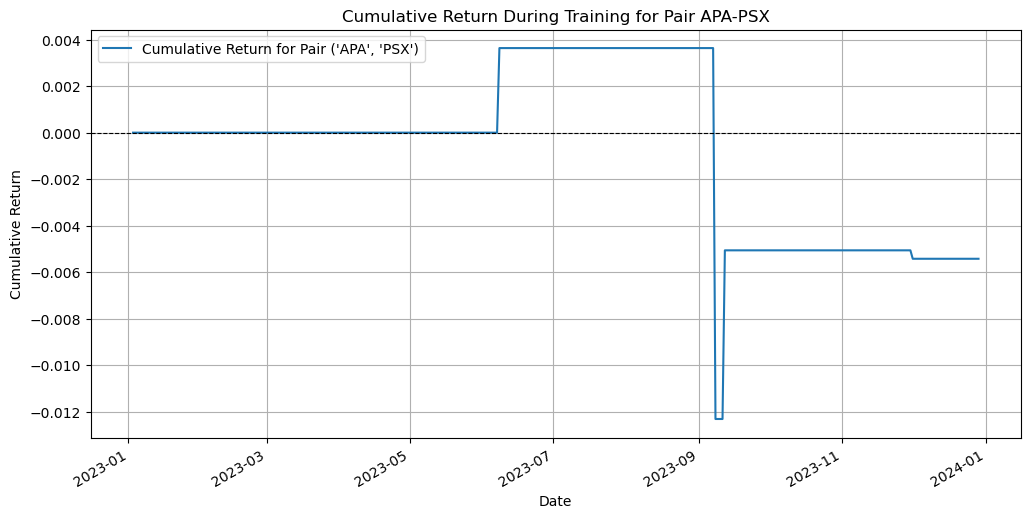

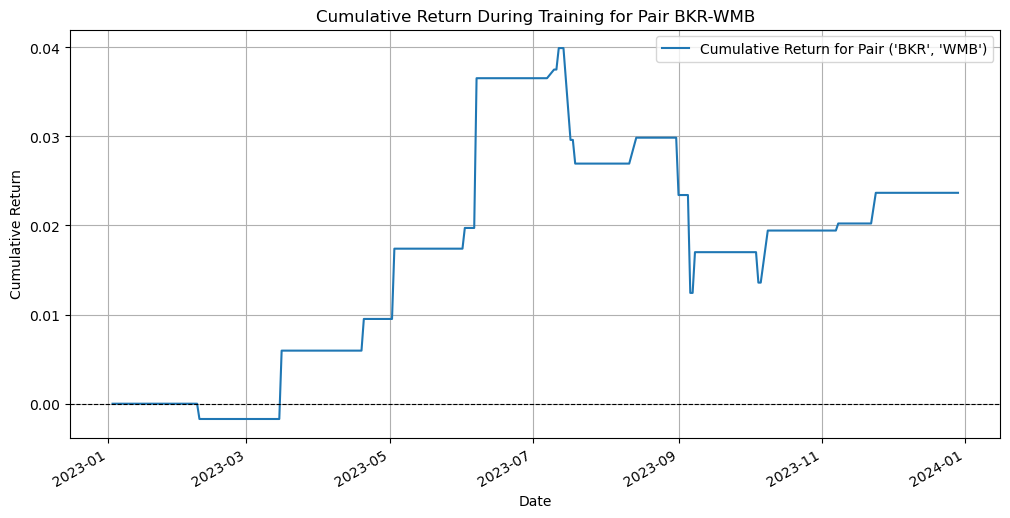

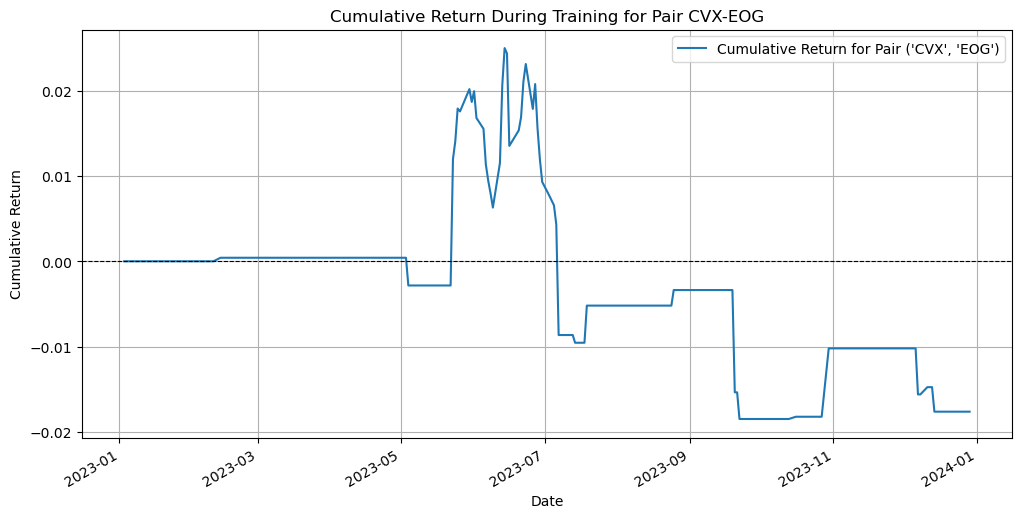

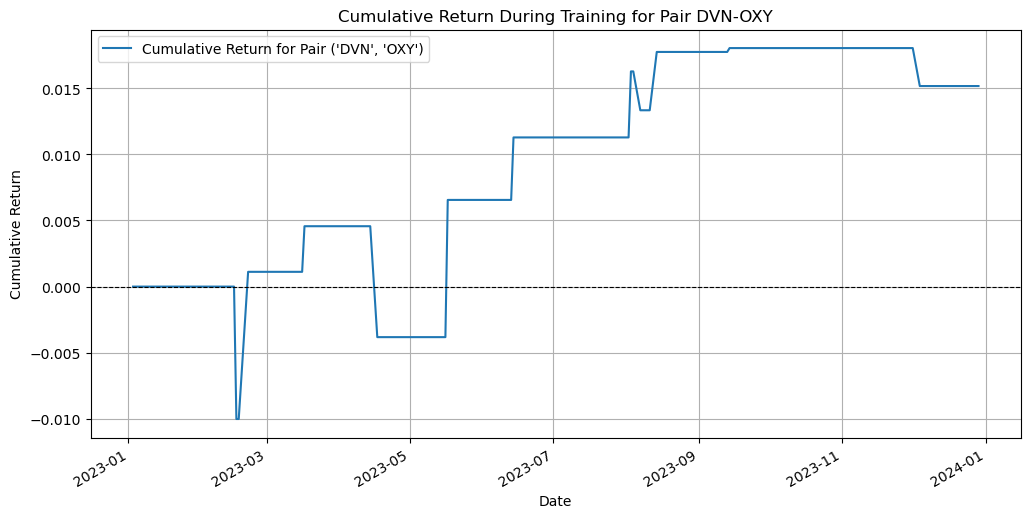

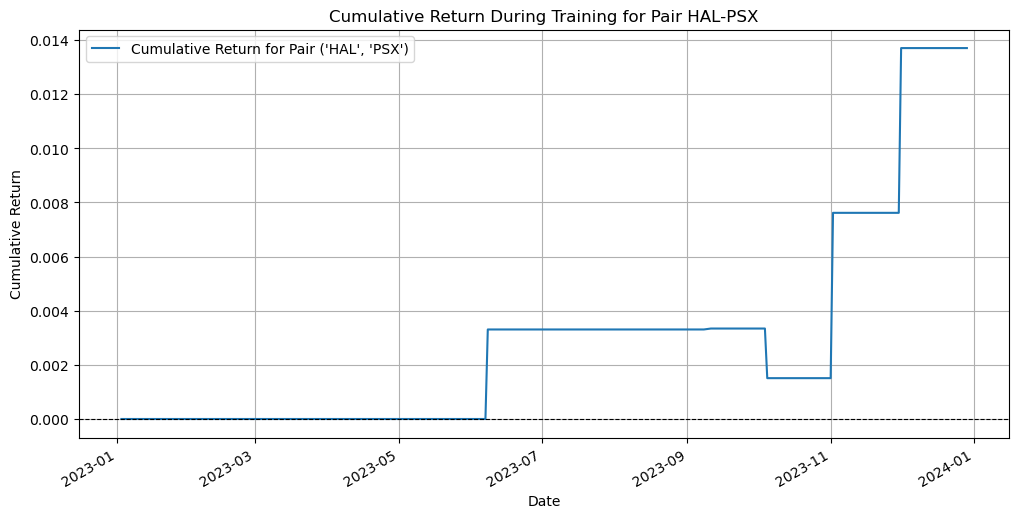

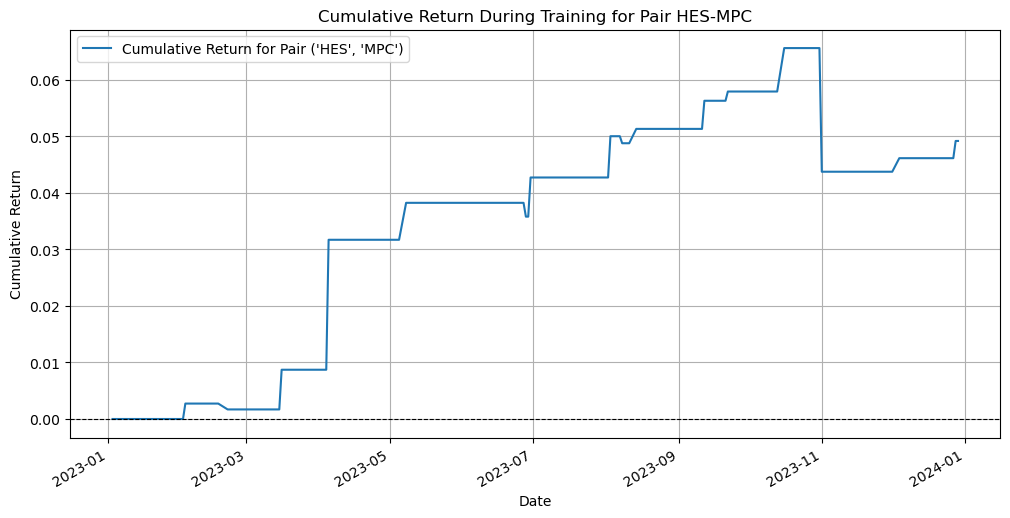

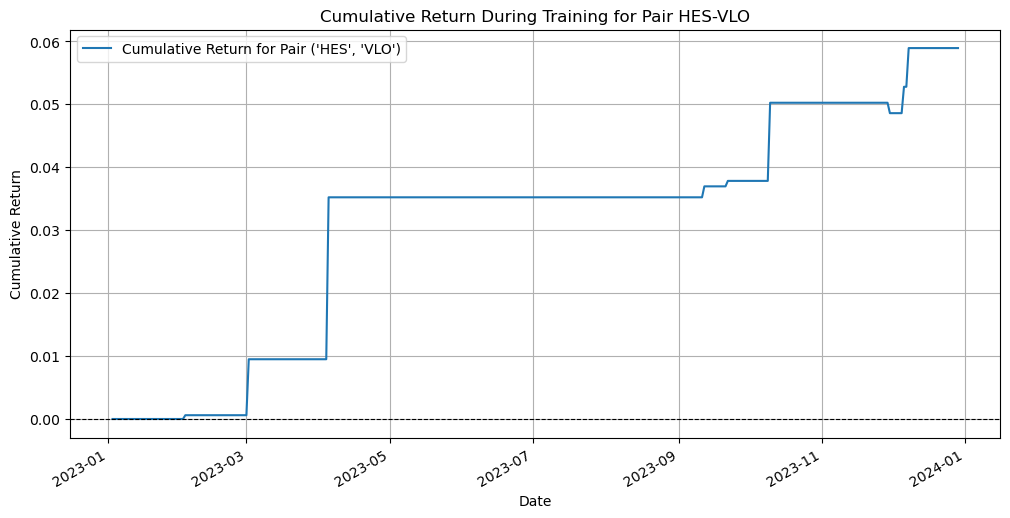

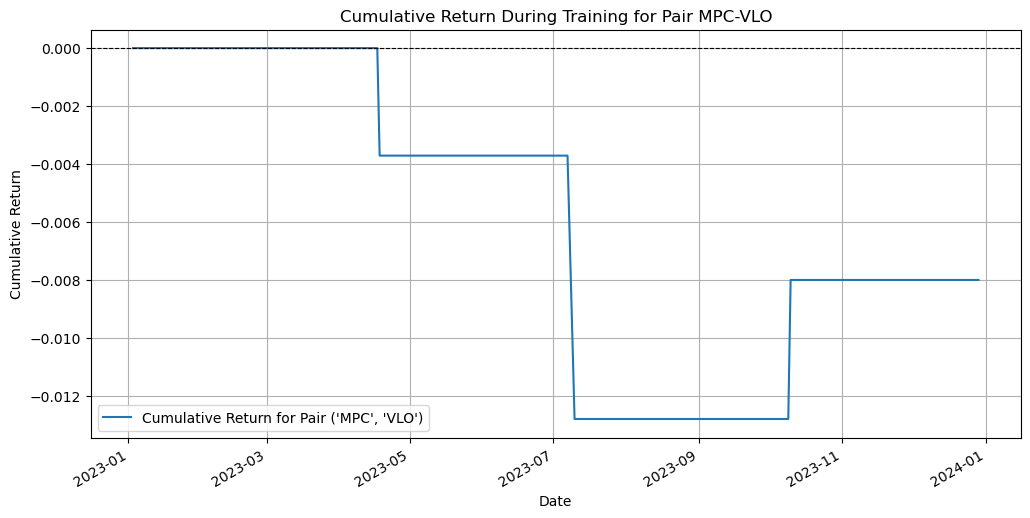

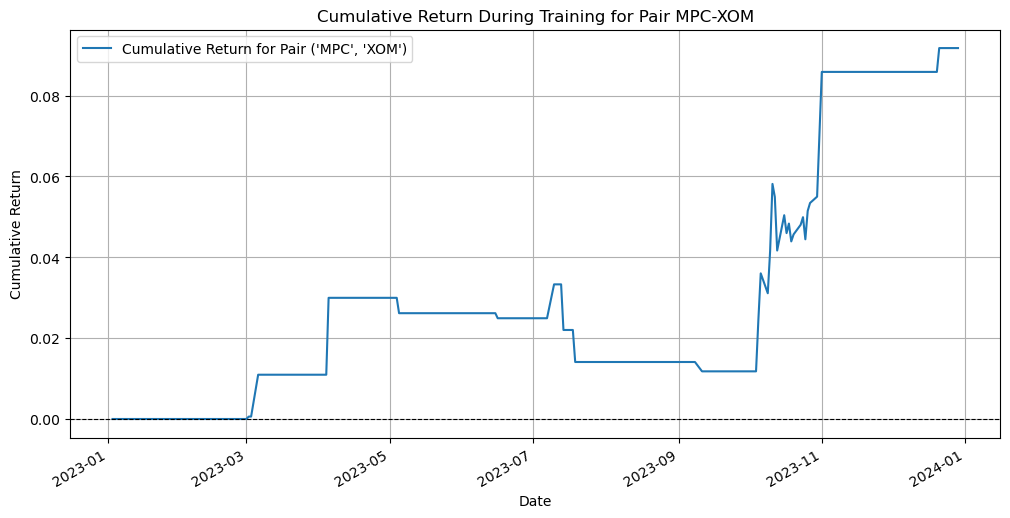

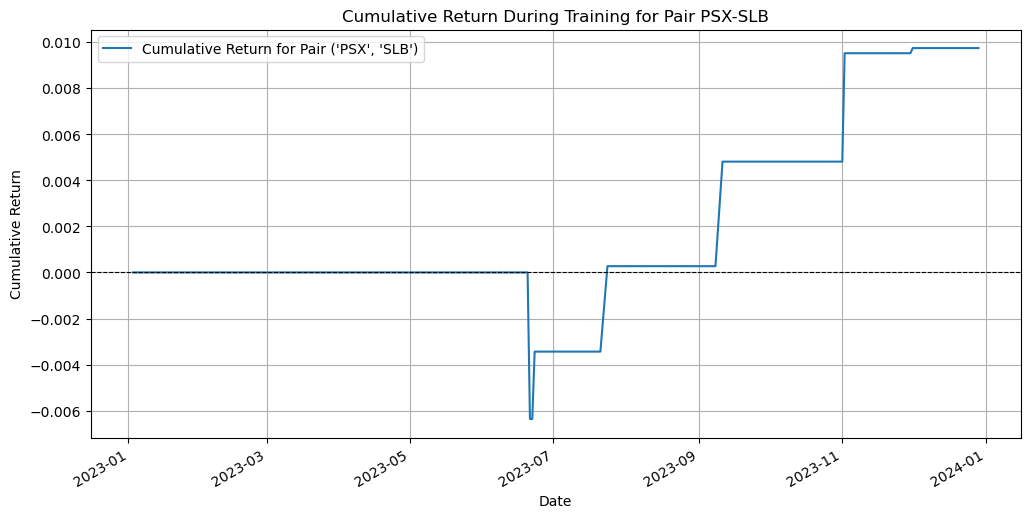

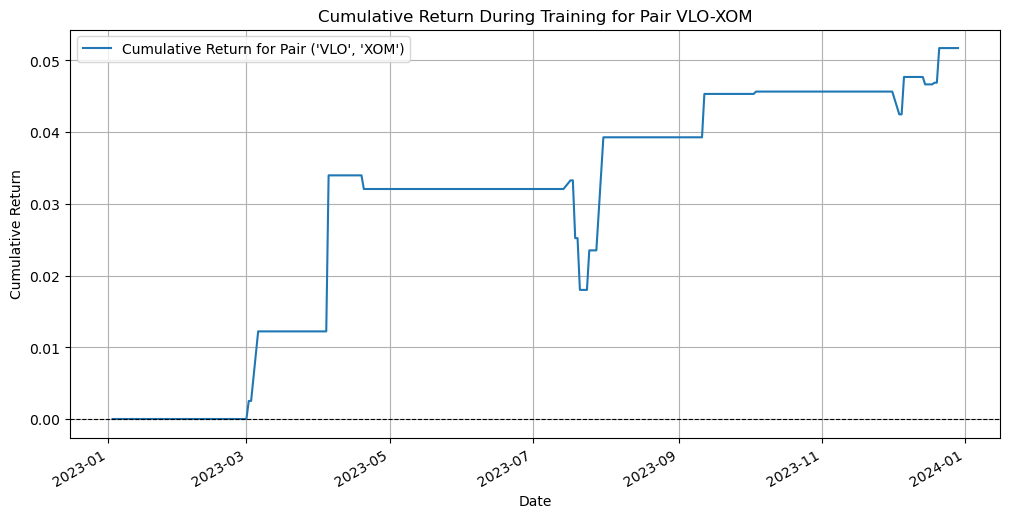

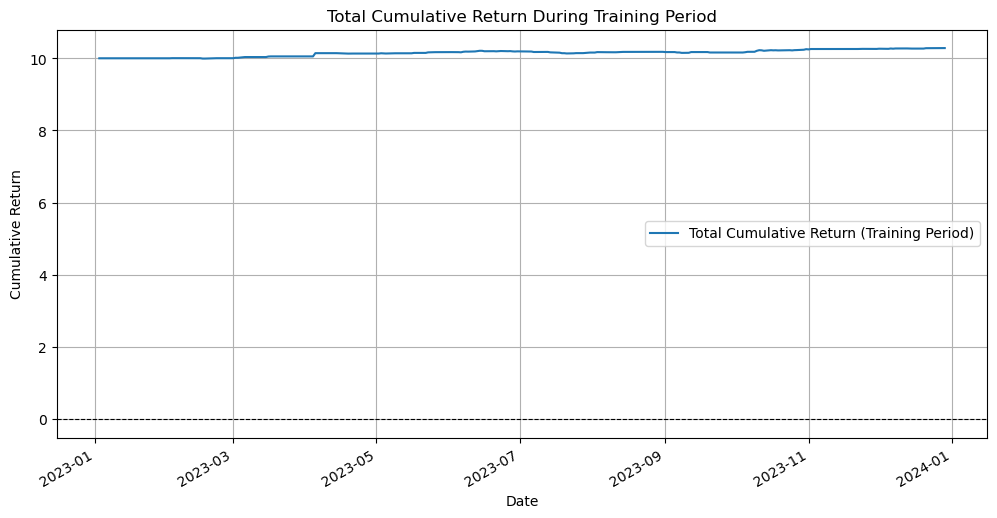

          Pair  Final Portfolio Value  Cumulative Return (%)
8   (MPC, XOM)             109.176002               9.176002
6   (HES, VLO)             105.891343               5.891343
10  (VLO, XOM)             105.171388               5.171388
5   (HES, MPC)             104.921131               4.921131
1   (BKR, WMB)             102.366826               2.366826
3   (DVN, OXY)             101.516802               1.516802
4   (HAL, PSX)             101.370015               1.370015
9   (PSX, SLB)             100.973804               0.973804
0   (APA, PSX)              99.457668              -0.542332
7   (MPC, VLO)              99.200228              -0.799772
2   (CVX, EOG)              98.235574              -1.764426


In [184]:
def plot_training_results(data, pairs, optimal_params, initial_cash=100):
    """
    Plot cumulative return for the training period based on optimized parameters.

    Parameters:
    - data: DataFrame of prices for the training period.
    - pairs: List of stock pairs.
    - optimal_params: Dictionary of optimized parameters for each pair.
    - initial_cash: Initial cash allocation for the portfolio.
    """
    total_portfolio_values = []
    pair_performance = []

    print("\nTraining Period Performance:")
    for pair in pairs:
        params = optimal_params[pair]
        portfolio_values, cumulative_return, final_portfolio_value = simulate_pair_strategy_fixed_exit(
            data, pair, params['Entry Level'], params['Take Profit'], params['Stop Loss'], initial_cash
        )
        total_portfolio_values.append(portfolio_values)

        # Store performance metrics for the pair
        pair_performance.append({
            'Pair': pair,
            'Final Portfolio Value': final_portfolio_value,
            'Cumulative Return (%)': cumulative_return.iloc[-1] * 100
        })

        # Plot cumulative return for each pair
        plt.figure(figsize=(12, 6))
        cumulative_return.plot(label=f'Cumulative Return for Pair {pair}')
        plt.title(f'Cumulative Return During Training for Pair {pair[0]}-{pair[1]}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
        plt.legend()
        plt.grid()
        plt.show()

    # Sum the portfolio values for all pairs
    total_portfolio_values = pd.concat(total_portfolio_values, axis=1).sum(axis=1)
    total_cumulative_return = (total_portfolio_values / initial_cash) - 1

    # Plot total cumulative return for the training period
    plt.figure(figsize=(12, 6))
    total_cumulative_return.plot(label='Total Cumulative Return (Training Period)')
    plt.title('Total Cumulative Return During Training Period')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.grid()
    plt.show()

    # Convert pair performance to a DataFrame for display
    training_performance_df = pd.DataFrame(pair_performance)
    training_performance_df.sort_values(by='Cumulative Return (%)', ascending=False, inplace=True)

    print(training_performance_df)


plot_training_results(training_data_params, stationary_pairs, optimal_params, initial_cash=100)
